In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

### Discrete Data + Probability

### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.5+ MB


In [6]:
df.request_method.value_counts()

"GET /api/v1/sales?page=2 HTTP/1.1"                 709
"GET /api/v1/items HTTP/1.1"                        464
"GET /api/v1/items?page=2 HTTP/1.1"                 291
"GET /api/v1/items?page=3 HTTP/1.1"                 219
"GET /api/v1/stores HTTP/1.1"                       162
                                                   ... 
"GET /api/v1//api/v1/items HTTP/1.1"                  1
"GET /api/v1/items&page=0 HTTP/1.1"                   1
"GET /api/v1/items/api/v1/items?page=3 HTTP/1.1"      1
"GET /api/v1/items?page=0 HTTP/1.1"                   1
"GET /api/v1/stores?page=2 HTTP/1.1"                  1
Name: request_method, Length: 220, dtype: int64

In [7]:
# begin cleaning up the timestamp by removing the brackets and extraneous tail

df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [8]:
df.head(2)

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,16/Apr/2019:19:34:42,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [9]:
# replace the first colon in the timestamp before year 
# to accomodate for pandas datetime
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
# reset index to time
df = df.set_index('timestamp')

In [10]:
df.head(2)

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""


In [43]:
df.request_agent.value_counts()

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [11]:
# clean up strings in columns with extra quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [12]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [13]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [14]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


<AxesSubplot:>

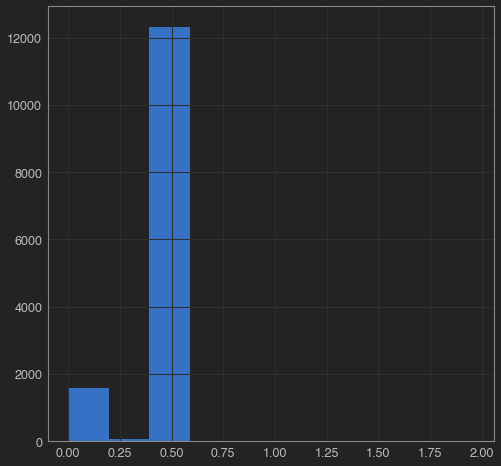

In [46]:
df.size_mb.hist()

In [16]:
# get the counts of request methods in the dataset
rq_df = df.request_method.value_counts(dropna=False).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'rq_count'})

In [17]:
# get the probability of that ip in the dataset
rq_df2 = (df.request_method.value_counts(dropna=False)/df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'rq_proba'})
# merge/join these together
rq_df = rq_df.merge(rq_df2)

In [18]:
rq_df.head()

,request_method,rq_count,rq_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154


In [19]:
rq_df.shape

(22, 3)

In [20]:
# alter the rq df to only see those where rate < 1% 
rq_df[rq_df.rq_proba < 0.01]

,request_method,rq_count,rq_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/itemsitems HTTP/1.1,3,0.000215
11,GET /api/v1/store HTTP/1.1,3,0.000215
12,GET /api/v1/sales/HTTP/1.1,3,0.000215


22
                                  request_method  rq_count  rq_proba
12                    GET /api/v1/sales/HTTP/1.1         3  0.000215
13                   GET /api/v1/sales/ HTTP/1.1         3  0.000215
14                     GET /api/v1items HTTP/1.1         2  0.000143
15              GET /api/v1/helloclass! HTTP/1.1         1  0.000072
16  GET /api/v1//api/v1/items/next_page HTTP/1.1         1  0.000072
17                          GET /api/v1 HTTP/1.1         1  0.000072
18             GET /api/v1/items&page=0 HTTP/1.1         1  0.000072
19                  GET /api/V1/HiZach! HTTP/1.1         1  0.000072
20                    GET /api/v1/items/HTTP/1.1         1  0.000072
21        GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1         1  0.000072


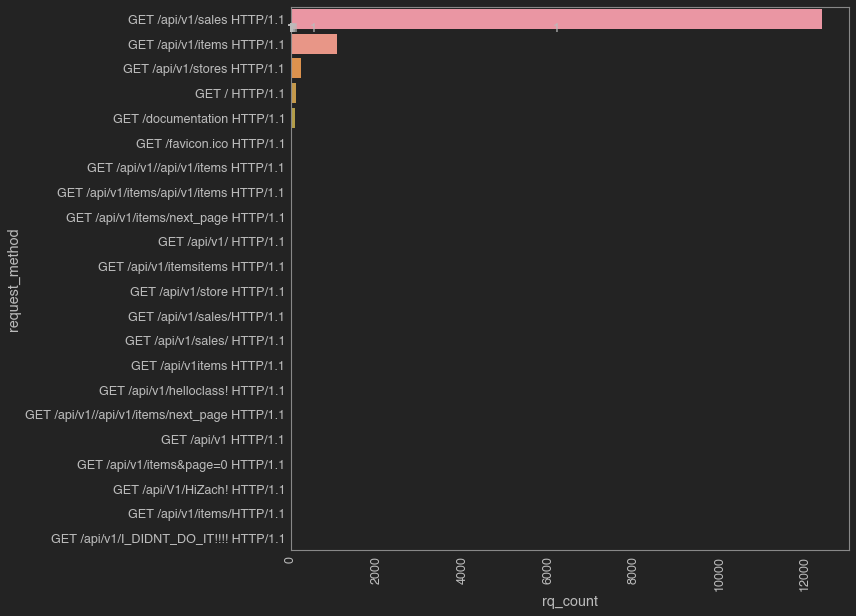

In [29]:
from jupyterthemes import jtplot
jtplot.style(grid=False, figsize=(10,10))

print(len(rq_df))

print(rq_df.tail(10))

plt.figure(figsize=(10, 10))
splot = sns.barplot(data=rq_df, y = 'request_method', x = 'rq_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
plt.xticks(rotation='vertical')
plt.show()

In [30]:
# create a training set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [31]:
train.size /df.size

0.9997138360280441

In [32]:
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [33]:
#Compute probabilities based on train sample
rq_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().rename(columns={'index': 'request_method', 'request_method': 'rq_proba'})

In [34]:
#Merge probabilities with all data (train + new data):
#Where the request_method is new, i.e. not seen in the training dataset, fill the probability with a value of 0.
df = df.reset_index().merge(rq_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [35]:
# value counts?
df[df['rq_proba'] == 0]

,ip,request_method,status,size,destination,request_agent,size_mb,rq_proba
timestamp,,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,0,python-requests/2.21.0,0.002441,0.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,2056327,0,python-requests/2.21.0,1.961066,0.0


Conditional Probabilities: Probabilities using 2 discrete variables
Probability of Status given request method:

In [36]:
# prob(A|B) = prob(A & B) / prob(B)
rq_probs = train.groupby('request_method').size().div(len(train))

status_given_request = pd.DataFrame(train.groupby(['request_method', 'status']).size().div(len(train)).\
                              div(rq_probs,
                                 axis=0,
                                 level='request_method').\
                              reset_index().\
                              rename(columns={0: 'proba_status_given_request'})
                              )

In [37]:
status_given_request

,request_method,status,proba_status_given_request
0,GET / HTTP/1.1,200,1.000000
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000
2,GET /api/v1 HTTP/1.1,200,1.000000
3,GET /api/v1/ HTTP/1.1,200,1.000000
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000
8,GET /api/v1/items HTTP/1.1,200,0.996244
9,GET /api/v1/items HTTP/1.1,499,0.003756


In [39]:
request_status_count = pd.DataFrame(train.groupby(['request_method', 'status'])['ip'].\
                              count().reset_index().\
                              rename(columns={'ip': 'rq_status_count'}))


rq_status = status_given_request.merge(request_status_count)
rq_status

,request_method,status,proba_status_given_request,rq_status_count
0,GET / HTTP/1.1,200,1.000000,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000,1
2,GET /api/v1 HTTP/1.1,200,1.000000,1
3,GET /api/v1/ HTTP/1.1,200,1.000000,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000,11
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000,1
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000,1
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000,1
8,GET /api/v1/items HTTP/1.1,200,0.996244,1061
9,GET /api/v1/items HTTP/1.1,499,0.003756,4


In [40]:
df = df.reset_index().merge(rq_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb,rq_proba,proba_status_given_request,rq_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.887577,0.999032,12391.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.887577,0.999032,12391.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.887577,0.999032,12391.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.887577,0.999032,12391.0


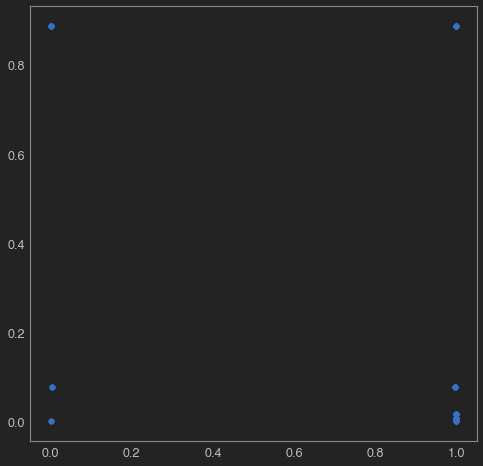

In [41]:
# scatter plot
plt.scatter(df.proba_status_given_request, df.rq_proba)
plt.show()

In [42]:
df[(df['proba_status_given_request'] > 0.9) & (df['rq_proba'] < 0.2)]

,ip,request_method,status,size,destination,request_agent,size_mb,rq_proba,proba_status_given_request,rq_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.016388,1.000000,229.0
2019-04-16 19:34:52,97.105.19.58,GET / HTTP/1.1,200,42,0,python-requests/2.21.0,0.000040,0.007657,1.000000,107.0
2019-04-16 19:34:53,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:53,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3659,0,python-requests/2.21.0,0.003489,0.076213,0.996244,1061.0
...,...,...,...,...,...,...,...,...,...,...
2019-04-17 06:15:05,24.26.242.9,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-17 06:15:06,24.26.242.9,GET /api/v1/stores HTTP/1.1,200,1328,0,python-requests/2.21.0,0.001266,0.016388,1.000000,229.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0


In [47]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
54.145.52.184         1
35.174.209.2          1
3.88.129.158          1
95.31.18.119          1
34.207.64.242         1
52.90.165.200         1
45.23.250.16          1
34.229.70.250         1
54.172.14.223         1
52.91.30.150          1
95.31.16.121          1
97.105.15.120         1
3.92.201.136          1
Name: ip, dtype: int64

In [48]:
from ip2geotools.databases.noncommercial import DbIpCity
response = DbIpCity.get('97.105.19.58', api_key='free')


In [49]:
response.city

'San Antonio (Downtown)'

In [51]:
ip_list = df.ip.unique().tolist()
ip_list

['97.105.19.58',
 '3.92.201.136',
 '52.90.165.200',
 '3.88.129.158',
 '34.207.64.242',
 '54.172.14.223',
 '34.229.70.250',
 '35.175.171.137',
 '54.145.52.184',
 '52.87.230.102',
 '35.174.209.2',
 '72.181.105.81',
 '70.121.214.34',
 '68.201.219.223',
 '173.173.113.51',
 '72.181.113.170',
 '52.91.30.150',
 '24.26.242.9',
 '45.23.250.16',
 '95.31.18.119',
 '95.31.16.121',
 '97.105.15.120']

In [53]:
response.to_csv(',')

'97.105.19.58,San Antonio (Downtown),Texas,US,29.4193459,-98.4780456'

In [57]:
geo = [(DbIpCity.get(ip, api_key='free')).to_csv(',') for ip in ip_list]
geo

['97.105.19.58,San Antonio (Downtown),Texas,US,29.4193459,-98.4780456',
 '3.92.201.136,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '52.90.165.200,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '3.88.129.158,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '34.207.64.242,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '54.172.14.223,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '34.229.70.250,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '35.175.171.137,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '54.145.52.184,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '52.87.230.102,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '35.174.209.2,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657',
 '72.181.105.81,San Antonio,Texas,US,29.4246002,-98.4951405',
 '70.121.214.34,San Antonio (North Central),Texas,US,33.9014063,-94.8297388',
 '68.201.219.223,San Antonio,T

In [114]:
geo_df = pd.DataFrame(geo)
geo_df.head()

,0
0,"97.105.19.58,San Antonio (Downtown),Texas,US,2..."
1,"3.92.201.136,Ashburn,Virginia,US,39.0300191000..."
2,"52.90.165.200,Ashburn,Virginia,US,39.030019100..."
3,"3.88.129.158,Ashburn,Virginia,US,39.0300191000..."
4,"34.207.64.242,Ashburn,Virginia,US,39.030019100..."


In [115]:
geo_df = geo_df[0].str.split(',', expand=True)
geo_df.head(5)

,0,1,2,3,4,5
0,97.105.19.58,San Antonio (Downtown),Texas,US,29.4193459,-98.4780456
1,3.92.201.136,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
2,52.90.165.200,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
3,3.88.129.158,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
4,34.207.64.242,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657


In [116]:
geo_df.columns = ['ip','city','state','country','latitude','longitude']
geo_df.head(1)

,ip,city,state,country,latitude,longitude
0,97.105.19.58,San Antonio (Downtown),Texas,US,29.4193459,-98.4780456


In [117]:
geo_df = geo_df.replace('None',0)
geo_df

,ip,city,state,country,latitude,longitude
0,97.105.19.58,San Antonio (Downtown),Texas,US,29.4193459,-98.4780456
1,3.92.201.136,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
2,52.90.165.200,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
3,3.88.129.158,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
4,34.207.64.242,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
5,54.172.14.223,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
6,34.229.70.250,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
7,35.175.171.137,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
8,54.145.52.184,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657
9,52.87.230.102,Ashburn,Virginia,US,39.030019100000004,-77.46964646557657


In [118]:
geo_df.latitude = geo_df.latitude.astype(float)
geo_df.longitude = geo_df.longitude.astype(float)

geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ip         22 non-null     object 
 1   city       22 non-null     object 
 2   state      22 non-null     object 
 3   country    22 non-null     object 
 4   latitude   22 non-null     float64
 5   longitude  22 non-null     float64
dtypes: float64(2), object(4)
memory usage: 1.2+ KB


In [119]:
geo_df.latitude = geo_df.latitude.apply(lambda x: 55.751244 if x == 0 else x)
geo_df.longitude = geo_df.longitude.apply(lambda x: 37.618423 if x == 0 else x)

In [120]:
import folium

In [121]:
center = [29.4193459, -98.4780456]
map_sat = folium.Map(location=center, zoom_start=8)

In [126]:
for ip in geo_df.ip:
    location = [geo_df[geo_df.ip == ip].latitude, geo_df[geo_df.ip == ip].longitude]
    folium.Marker(location, tooltip= f'ip:{(geo_df[geo_df.ip == ip]).ip}\n City:{(geo_df[geo_df.ip == ip]).city}').add_to(map_sat)
    

map_sat